In [1]:
from __future__ import annotations
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import os, sys

# Load StarCraft2Sensor stuff
ipynb_dir = os.path.dirname(os.path.realpath("__file__"))
model_dir = os.path.join(ipynb_dir, 'models')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
code_root = os.path.join(ipynb_dir, '..')
sys.path.append(code_root)  # Needed for import below

from sc2sensor.dataset import StarCraftSensor
from sc2sensor.utils.unit_type_data import NONNEUTRAL_CHANNEL_TO_ID, NONNEUTRAL_ID_TO_NAME
CHANNEL_TO_NAME = [NONNEUTRAL_ID_TO_NAME[NONNEUTRAL_CHANNEL_TO_ID[i]] for i in range(len(NONNEUTRAL_CHANNEL_TO_ID))]

data_root = os.path.join(code_root, 'data') # Data root directory
data_subdir = 'starcraft-sensor-dataset'

In [2]:
# Create subclass of original dataset for next window prediction
class NextWindowDataset(StarCraftSensor):
  def __init__(self, *args, max_samples=None, **kwargs):
    assert 'use_sparse' not in kwargs, 'Cannot set use_sparse with this dataset.'
    assert 'compute_labels' not in kwargs, 'Cannot set use_sparse with this dataset.'
    super().__init__(*args, use_sparse=True, compute_labels=False, **kwargs)
    self.max_samples = max_samples
    
    # Sort data so that next index is merely + 1
    self.metadata = self.metadata.sort_values(['static.replay_name', 'dynamic.window_idx']).reset_index(drop=True)
    md = self.metadata
    
    # Get starting window indices
    start_windows = md[(md['dynamic.num_windows'] > 1) 
                       & (md['dynamic.window_idx'] < (md['dynamic.num_windows'] - 1))]
    self.start_idx = start_windows.index

  def __getitem__(self, idx):
    # Get original indices of start and end based on input 
    md = self.metadata
    # Assumes sorted
    orig_idx = self.start_idx[idx]
    next_idx = orig_idx + 1
    # Only sanity check first and last as this may be expensive
    if idx == 0 or idx == len(self) - 1:
      assert md['static.replay_name'][orig_idx] == md['static.replay_name'][next_idx], 'Replays are not the same'
      assert md['dynamic.window_idx'][orig_idx] + 1 == md['dynamic.window_idx'][next_idx], 'Window indices are not adjacent'

    # Get combined hyperspectral images
    def get_hyperspectral_dense(idx):
      # Concatenate player1 and player2 hyperspectral
      replay_file, window_idx = self._get_replay_and_window_idx(idx)
      with np.load(replay_file) as data:
        player_1_hyperspectral = self._extract_hyperspectral(
          'player_1', data, window_idx)
        player_2_hyperspectral = self._extract_hyperspectral(
          'player_2', data, window_idx)
      return torch.concat([player_1_hyperspectral.to_dense(), 
                           player_2_hyperspectral.to_dense()], 
                          dim=-3).float()
    windows = [get_hyperspectral_dense(idx) for idx in [orig_idx, next_idx]] 
    x = windows[0]
    y = windows[1] - windows[0] # Compute diff
    return x, y

  def __len__(self):
    if self.max_samples is not None:
      return min(self.max_samples, len(self.start_idx))
    else:
      return len(self.start_idx)

In [3]:
# Load datasets
max_samples = 1000
next_window_train = NextWindowDataset(root=data_root, subdir=data_subdir, train=True, max_samples=max_samples)

single = next_window_train[-1]
n_input_channels = single[0].shape[0]  # Needed for preprocessor to get down to 3 channels
print(f'Num train: {len(next_window_train)}') #, Num test: {len(next_window_test)}')
#print(f'Num train: {len(next_window_train)}, Num test: {len(next_window_test)}')
print(f'x.shape: {single[0].shape}, y.shape: {single[1].shape}')

Using cached CSV metadata
Not computing labels
Post-processing metadata
Finished dataset init
Num train: 1000
x.shape: torch.Size([340, 64, 64]), y.shape: torch.Size([340, 64, 64])


In [4]:
# Create fastai dataloaders given the PyTorch dataset
from fastai.data.all import Transform, DataBlock, RandomSplitter, L
class AddChannelCodes(Transform):
  "Add the code metadata to a `TensorMask`"
  def __init__(self, codes=None):
      self.codes = codes
      if codes is not None: self.vocab,self.c = codes,len(codes)

  def decodes(self, o):
      if self.codes is not None: o.codes=self.codes
      return o
    
# HACK: Put all instances in both "train" and "valid"
# From https://forums.fast.ai/t/solved-not-splitting-datablock/84759/3
def all_splitter(o): return L(int(i) for i in range(len(o))), L(int(i) for i in range(len(o)))
    
SC2_CODES = [
  f'{player}_{name}'
  for player in ['P1','P2']
  for name in CHANNEL_TO_NAME
]
def create_dataloaders_from_dataset(dataset, splitter=None, **kwargs):
  # Needs to have reference to dataset for closures
  assert 'get_x' not in kwargs
  assert 'get_y' not in kwargs
  assert 'get_items' not in kwargs
  splitter = splitter if splitter is not None else RandomSplitter(seed=0)
  assert len(SC2_CODES) == dataset[0][0].shape[0], 'Number of codes does not match number of channels'
  block = DataBlock(
    get_items=lambda d: list(range(len(d))),
    get_x=lambda idx: dataset[idx][0],
    get_y=lambda idx: dataset[idx][1],
    blocks=None, # These are just transforms
    splitter=splitter,
    item_tfms=[AddChannelCodes(SC2_CODES)],
  )
  return block.dataloaders(dataset, **kwargs)

batch_size = 32
dls = create_dataloaders_from_dataset(next_window_train, batch_size=batch_size)

In [5]:
#from fastai.vision.all import unet_learner, resnet18, resnet34, xresnet18, xresnet34_deep, xresnet34_deeper
from fastai.vision.all import *
from fastai.callback.all import SaveModelCallback, EarlyStoppingCallback
import segmentation_models_pytorch as smp

experiments = [
  'resnet18',
  #'resnet34',
  #'efficentnet-b2',
  #'efficentnet-b4',
  #'densenet121',
  #'densenet169',
]

shared_kwargs = dict(dls=dls, loss_func=nn.MSELoss(), path=Path(code_root), model_dir='models')
for arch in experiments:
  name = 'unet_' + arch
  model = smp.Unet(
    encoder_name=arch,        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights='imagenet',     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=len(SC2_CODES),                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=len(SC2_CODES),                      # model output channels (number of classes in your dataset)
    activation=None, 
  )
  #print(model)
  learner = Learner(model=model, **shared_kwargs)
  
  callbacks = [
    EarlyStoppingCallback(patience=1),
    SaveModelCallback(fname=f'next_window_{len(next_window_train)}_{name}', with_opt=True),
  ]
  # Does one epoch of fine tune with frozen weights, then normal epochs unfrozen
  learner.fine_tune(10, cbs=callbacks)

print(f'Final train loss: {learner.validate(dl=dls.train)}')
print(f'Final valid loss: {learner.validate(dl=dls.valid)}')

epoch,train_loss,valid_loss,time
0,4.089171,4.334961,00:09


Better model found at epoch 0 with valid_loss value: 4.3349609375.


epoch,train_loss,valid_loss,time
0,4.062285,3.942143,00:08
1,4.036158,3.917409,00:08
2,4.016632,4.030963,00:08


Better model found at epoch 0 with valid_loss value: 3.942143440246582.
Better model found at epoch 1 with valid_loss value: 3.9174089431762695.
No improvement since epoch 1: early stopping


Final train loss: [4.015681743621826]


Final valid loss: [3.9174089431762695]


In [6]:
next_window_test = NextWindowDataset(root=data_root, subdir=data_subdir, train=False, max_samples=max_samples)
dls_test = create_dataloaders_from_dataset(next_window_test, splitter=all_splitter, batch_size=batch_size)
print(f'Final test loss: {learner.validate(dl=dls_test.valid)}')

Using cached CSV metadata
Not computing labels
Post-processing metadata
Finished dataset init


Final test loss: [5.733017444610596]


In [41]:
%pdb on
from fastai.metrics import AvgMetric, Metric
from sklearn.metrics import confusion_matrix

# Example that takes an average (while considering batch size `bs`)
# %% ../nbs/13a_learner.ipynb 119
class BinnedConfusionMatrixMetric(Metric):
  """Micro confusion matrix (enables computation of micro-versions of other metrics)
     (i.e., will give total percentages over all batches)
  """
  #def __init__(self, func):  self.func = func
  def reset(self):           self.total,self.count = 0.0,0
  def accumulate(self, learn):
    bs = find_bs(learn.yb)
    # Scales by batch size (later divided by batch size)
    self.total += learn.to_detach(self._metric_batch(learn.pred, *learn.yb)) * bs
    #print(self.total)
    self.count += bs
  def _metric_batch(self, y_pred, y_true):
    # Computes confusion matrix for this batch (Normalized to percentages)
    # First convert to 1, 0, or -1
    def bin_data(y):
      near_zero_mask = y.abs().lt(1/255.0)
      y = torch.sign(y)
      y[near_zero_mask] = 0
      return y
    y_pred, y_true = bin_data(y_pred), bin_data(y_true)
    labels = [-1.0, 1.0, 0.0]
    # Sklearn confusion_matrix is far too slow, vectorized version below
    cm = np.zeros((len(labels), len(labels)))
    for i, lab_i in enumerate(labels):
      for j, lab_j in enumerate(labels):
        cm[i, j] = torch.logical_and(y_true == lab_i, y_pred == lab_j).float().mean().cpu().numpy()
    return cm

  @property
  def value(self): return self.total/self.count if self.count != 0 else None
  @property
  def name(self):  return self.func.func.__name__ if hasattr(self.func, 'func') else  self.func.__name__ 
  
learner.metrics = [BinnedConfusionMatrixMetric()]
out = learner.validate(dl=dls_test.valid)
out[1]

Automatic pdb calling has been turned ON


array([[8.41208081e-05, 2.81350536e-05, 5.50680730e-06],
       [5.23480595e-05, 4.69267013e-05, 7.11095489e-06],
       [3.58865055e-01, 4.08951750e-01, 2.31959068e-01]])

In [32]:
out[1]

array([[2.31959068e-01, 4.08951750e-01, 0.00000000e+00],
       [7.11095489e-06, 4.69267013e-05, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

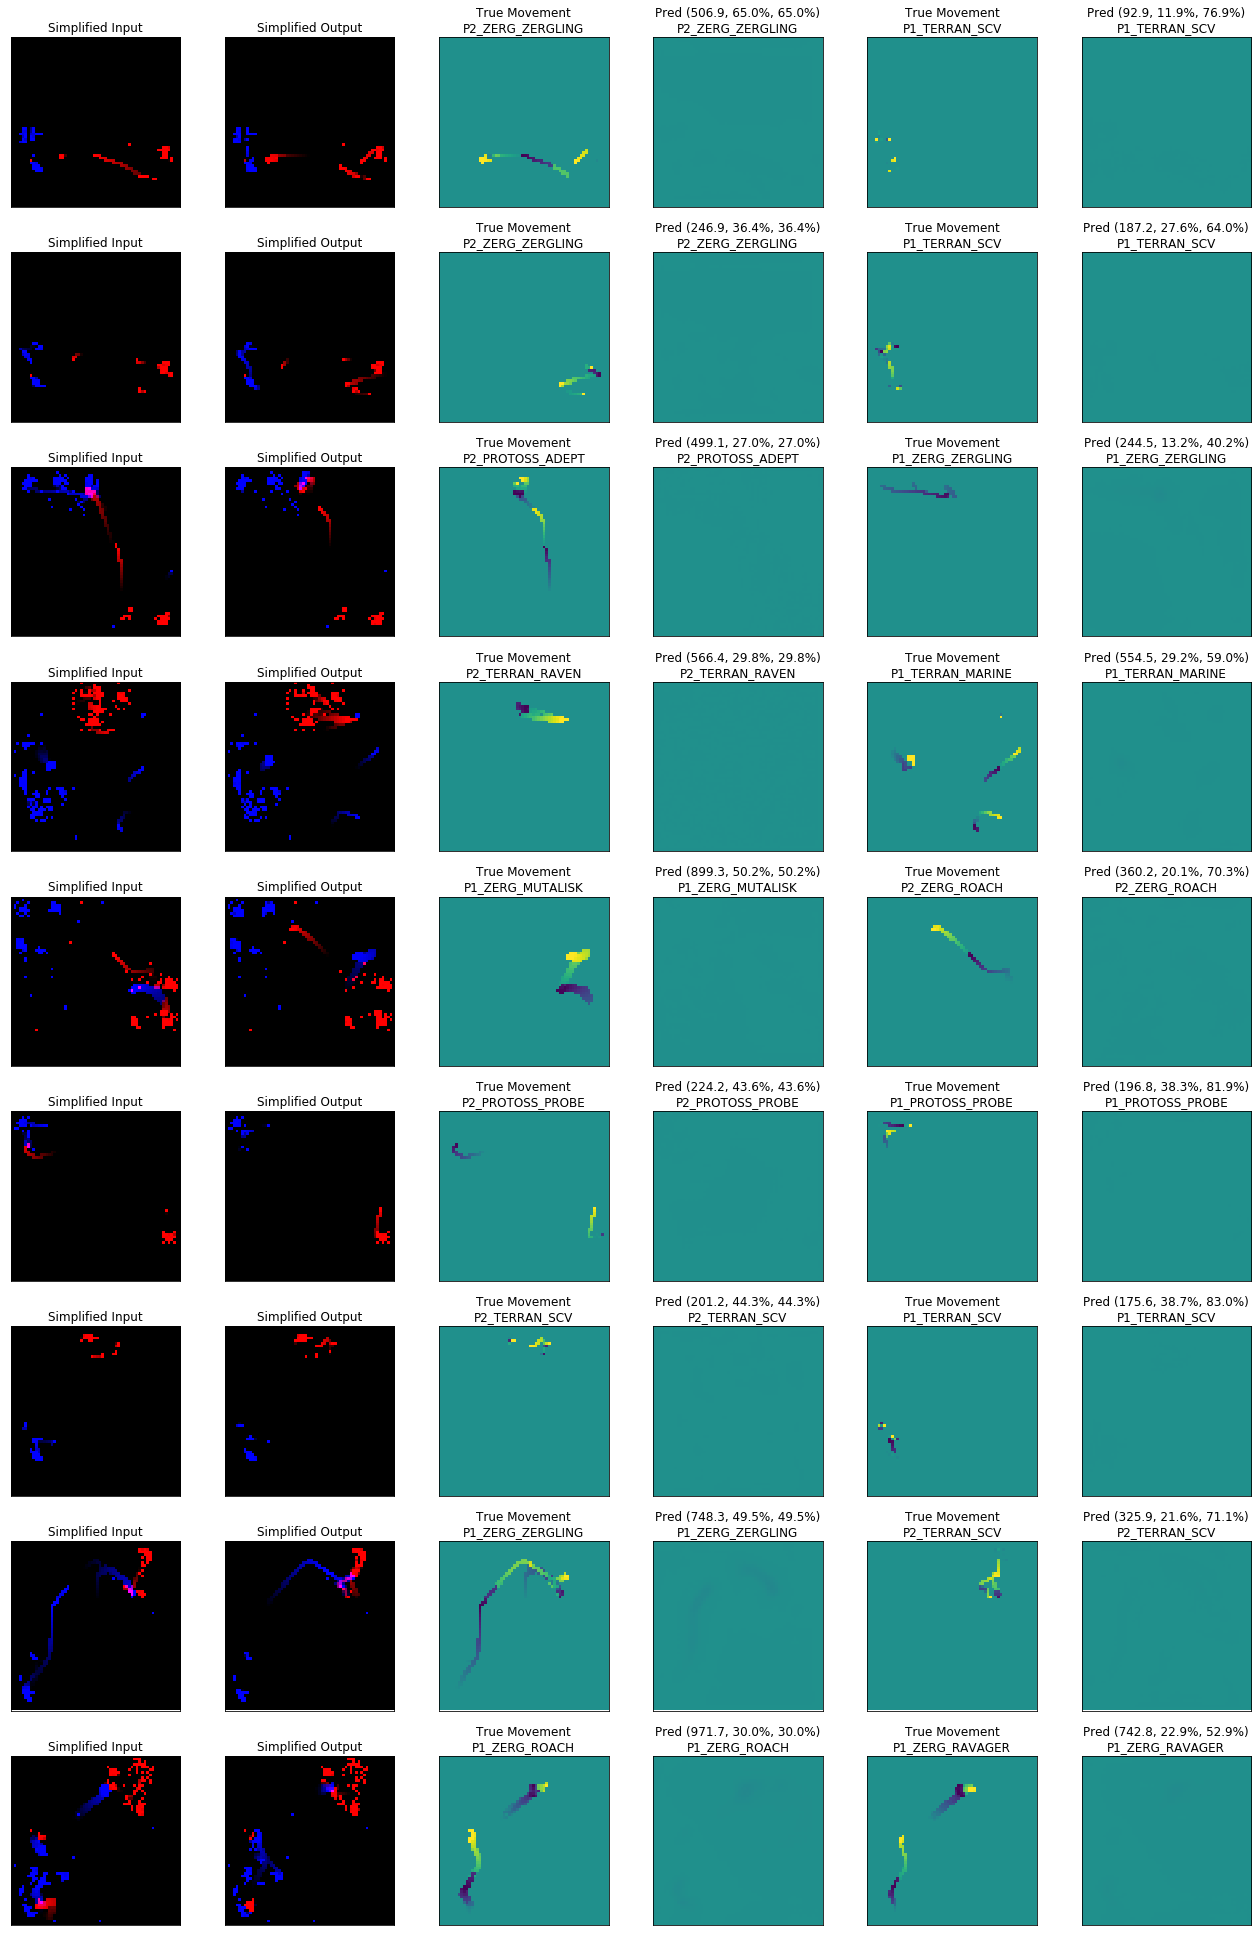

In [7]:
# Qualitative results
def show_next_window_result(orig, diff, diff_pred, loss_func, max_show=2, axes=None):
  nc = 2 + 2*max_show
  if axes is None:
    axes = plt.subplots(1, nc, figsize=[3, 3*nc])
  assert len(axes) == nc
  orig, diff, diff_pred = orig.cpu(), diff.cpu(), diff_pred.cpu()
  loss_per_channel = torch.stack([
    loss_func(d, p)
    for d, p in zip(diff, diff_pred)
  ])
  sorted_loss_per_channel, sorted_channel_idx = torch.sort(loss_per_channel, descending=True)
  
  def show_full(hyper, ax, label, ylabel=None):
    p1, p2 = torch.chunk(hyper, 2, dim=0)
    ax.imshow(torch.stack([p2.max(axis=0)[0], torch.zeros_like(p1.max(axis=0)[0]), p1.max(axis=0)[0]]).permute(1, 2, 0)/255.0)
    #ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(label)
    if ylabel is not None:
      ax.set_ylabel(ylabel)
      
  axi = iter(axes)
  show_full(orig, next(axi), 'Simplified Input')
  show_full(orig + diff, next(axi), 'Simplified Output')
  
  total_loss = loss_per_channel.sum()
  max_val = 255 # For scaling images
  for ii, (ci, closs, _) in enumerate(zip(sorted_channel_idx, sorted_loss_per_channel, range(max_show))):
    ax = next(axi)
    ax.imshow(diff[ci], vmin=-max_val, vmax=max_val)
    #ax.set_xlabel(codes[ci])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'True Movement\n{SC2_CODES[ci]}')
    
    ax = next(axi)
    ax.imshow(diff_pred[ci], vmin=-max_val, vmax=max_val)
    #ax.set_xlabel(codes[ci])
    ax.set_xticks([])
    ax.set_yticks([])
    
    assert closs == loss_per_channel[ci], 'Should match'
    perc_loss = closs / total_loss
    cum_perc_loss = sorted_loss_per_channel[:(ii+1)].sum() / total_loss
    ax.set_title(f'Pred ({closs:.1f}, {perc_loss*100:.1f}%, {cum_perc_loss*100:.1f}%)\n{SC2_CODES[ci]}')
  
def show_batch(learner, ds_idx=1, dl=None, max_n=9, shuffle=True, **kwargs):
  if dl is None: dl = learner.dls[ds_idx].new(shuffle=shuffle)
  b = dl.one_batch()
  _,_,preds = learner.get_preds(dl=[b], with_decoded=True)
  
  max_show = 2
  nr, nc = min(max_n, b[0].shape[0]), 2 + 2*max_show
  fig, axes_mat = plt.subplots(nr, nc, figsize=[nc*3, nr*3])
  axes_mat = axes_mat.reshape((nr, nc)) # Ensure matrix
  for ii, (orig, diff, diff_pred, axes) in enumerate(zip(b[0], b[1], preds, axes_mat)):
    show_next_window_result(orig, diff, diff_pred, learner.loss_func, max_show=max_show, axes=axes)
  fig.tight_layout()
  
show_batch(learner, shuffle=False)

Smallest losses


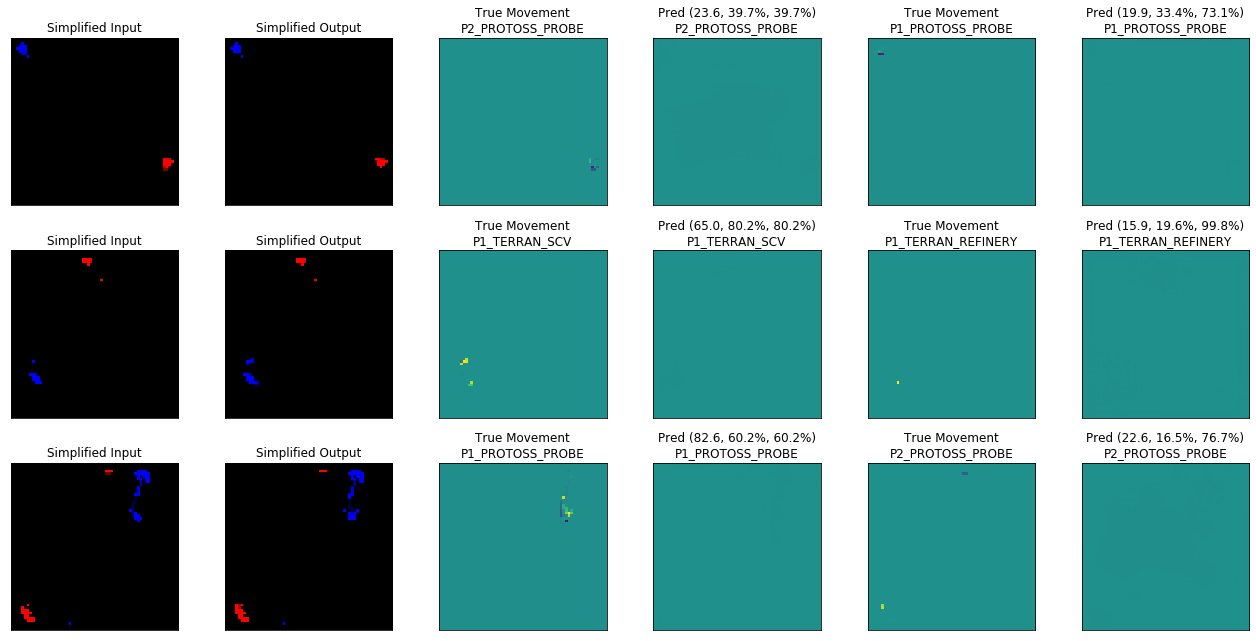

Largest losses


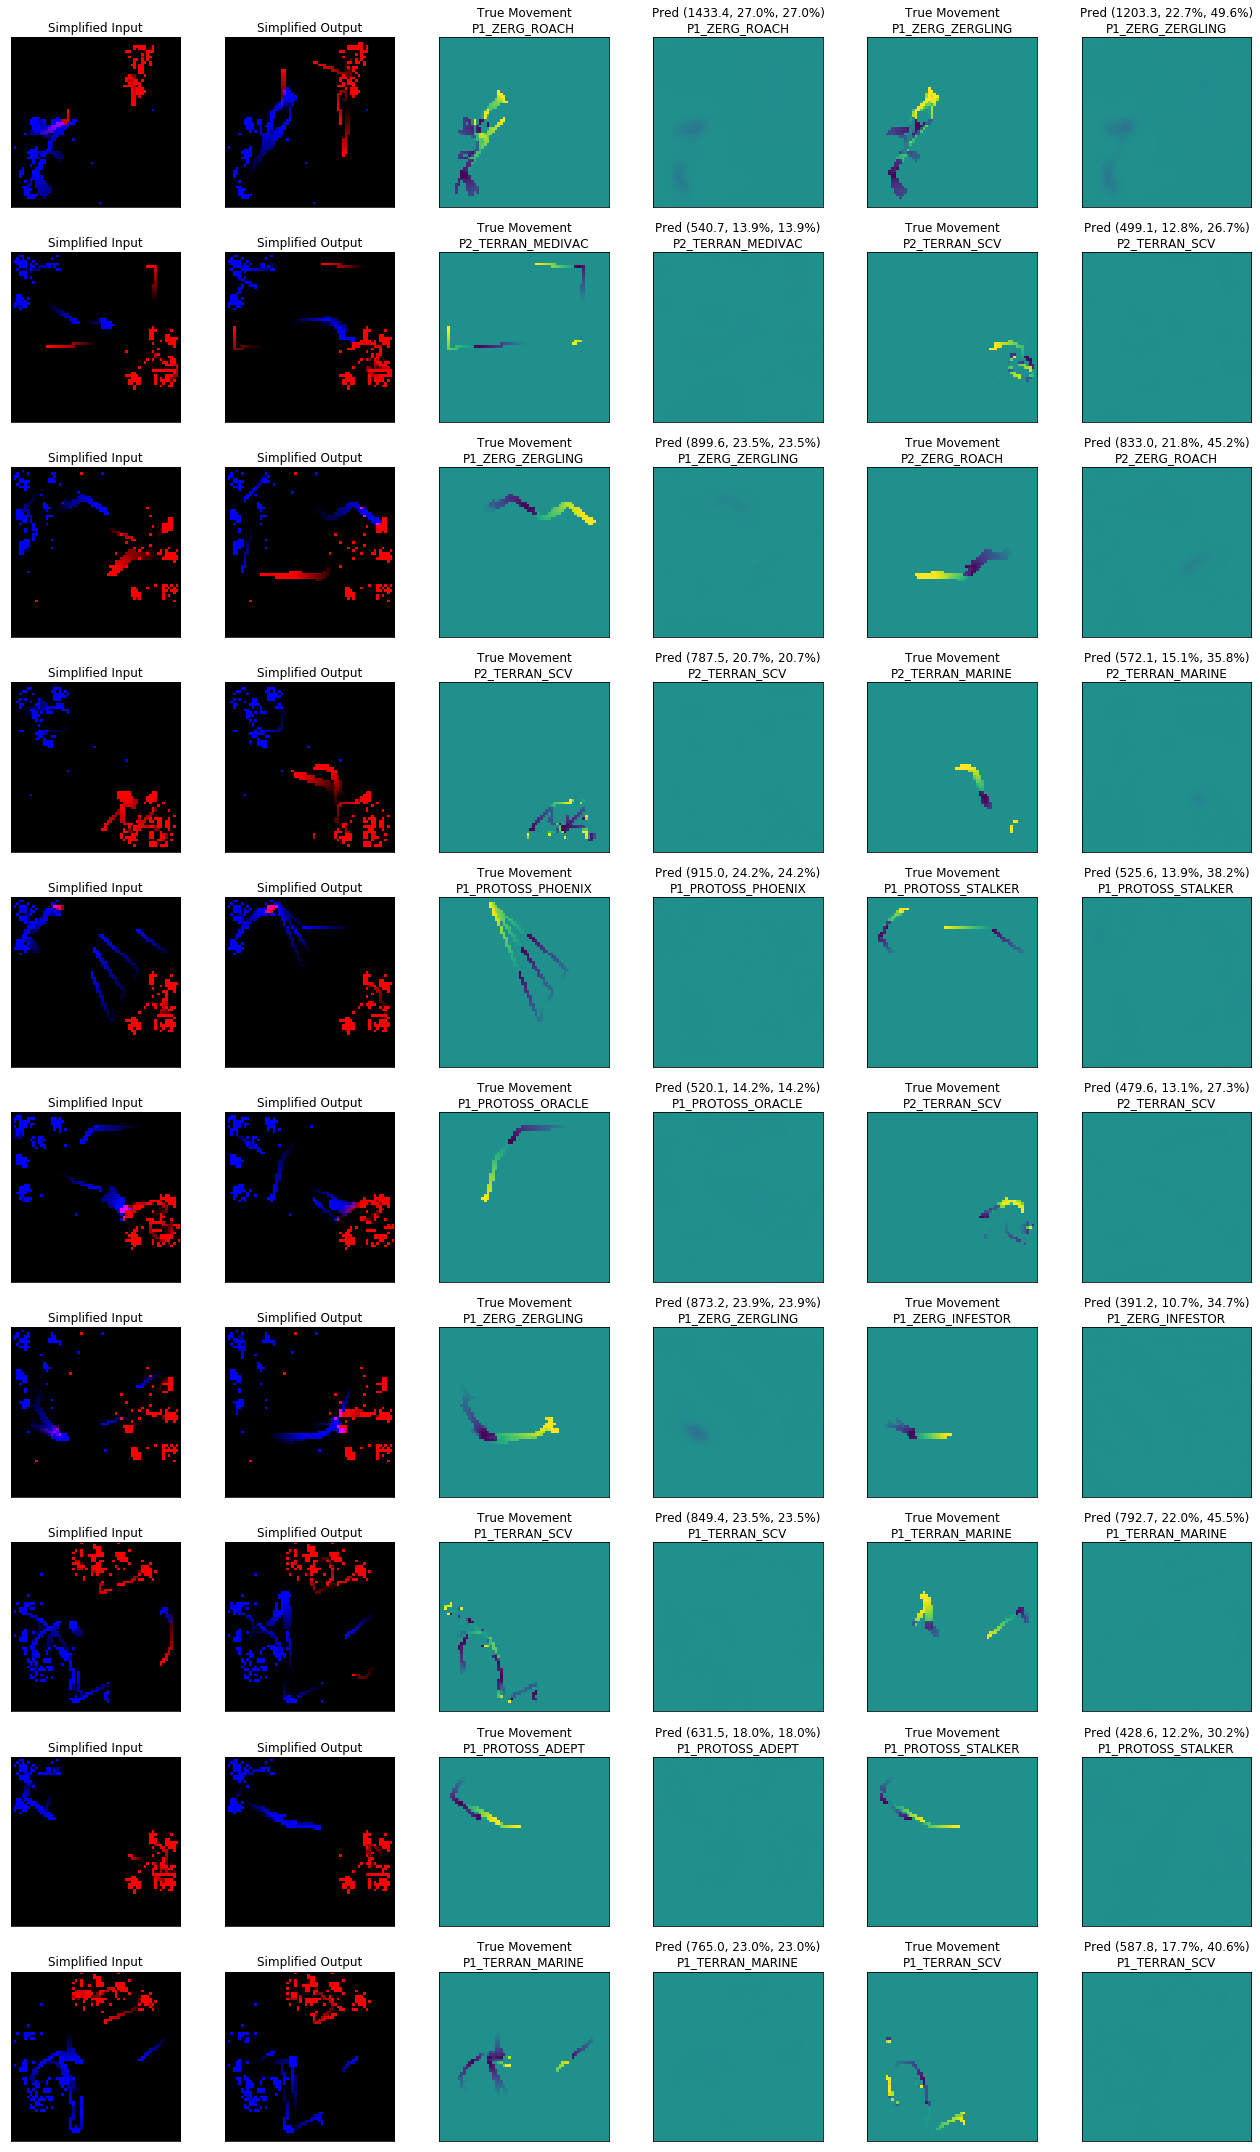

In [8]:
from fastai.vision.all import Interpretation
from fastcore.all import typedispatch

# Automatically overrides a function for inputs of x and y
# Called by plot_top_losses method of Interpretation
@typedispatch
def plot_top_losses(x:torch.Tensor, y:torch.Tensor, its, outs, preds, losses, loss_func, **kwargs):
  # x and y(B, C, H, W)
  # its has len of B and then is both (x, y) together
  # outs has len of B and then just y
  # preds is len of B and the out
  # losses is len of B
  
  max_show = 2
  nr, nc = x.shape[0], 2 + 2 * max_show
  fig, axes_mat = plt.subplots(nr, nc, figsize=[nc*3, nr*3])
  axes_mat = axes_mat.reshape((nr, nc)) # Ensure matrix
  
  for ii, (orig, diff, diff_pred, axes) in enumerate(zip(x, y, preds, axes_mat)):
    show_next_window_result(orig, diff, diff_pred, loss_func, max_show=max_show, axes=axes)
  fig.tight_layout()
  fig.patch.set_facecolor('white') # Set background to white
  plt.show()

interpret = Interpretation.from_learner(learner)
print('Smallest losses')
interpret.plot_top_losses(k=3, largest=False, loss_func=learner.loss_func)
print('Largest losses')
interpret.plot_top_losses(k=10, largest=True, loss_func=learner.loss_func)

OLD Visualization just in case


max_val is not correct anymore
max_val is not correct anymore
max_val is not correct anymore
max_val is not correct anymore


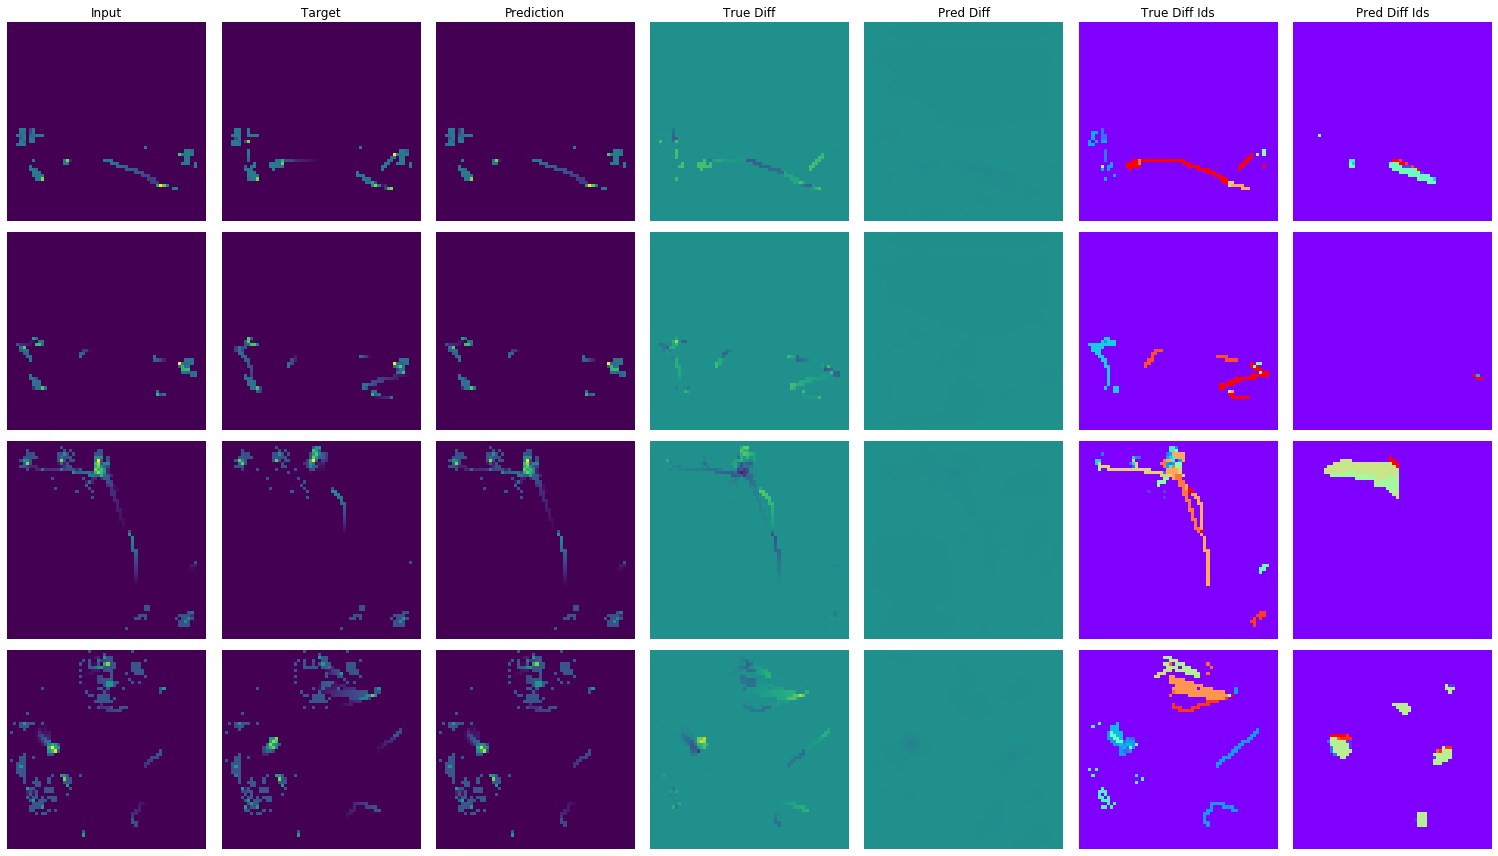

In [9]:
print('OLD Visualization just in case')
# Qualitative results
#learner.show_results()
#def show_results(self, ds_idx=1, dl=None, max_n=9, shuffle=True, **kwargs):
self = learner
ds_idx=1
dl=None
max_n=4
shuffle=True
shuffle=False
kwargs={}
if dl is None: dl = self.dls[ds_idx].new(shuffle=shuffle)
b = dl.one_batch()
_,_,preds = self.get_preds(dl=[b], with_decoded=True)
#dl.show_results(b, preds, max_n=max_n, **kwargs)
def show_mean_values(im, ax, max_val=None, vmin=0, vmax=1):
  im_mean = im.mean(axis=0)
  #p1, p2 = torch.chunk(im, 2, dim=0)
  #p1_mean = p1.max(axis=0)[0]
  #p2_mean = p2.max(axis=0)[0]
  #neutral_mean = torch.zeros_like(p1_mean)
  #im_mean = torch.stack([p2_mean, neutral_mean, p1_mean]).permute(1, 2, 0)
  if max_val is None:
    max_val = im_mean.max()
    #max_val = max(255.0, im_mean.max()) #im_mean.max()
  im_mean = im_mean / max_val
  ax.imshow(im_mean, vmin=vmin, vmax=vmax)
  ax.axis('off')
  
def show_ids(im, ax):
  ax.imshow(im, cmap='rainbow')
  ax.axis('off')
  
nr, nc = min(max_n, b[0].shape[0]), 7
fig, axes_mat = plt.subplots(nr, nc, figsize=[nc*3, nr*3])
axes_mat = axes_mat.reshape((nr, nc)) # Ensure matrix
for ii, (orig, diff, diff_pred, axes) in enumerate(zip(b[0], b[1], preds, axes_mat)):
  axi = iter(axes)
  #max_val = target.mean(axis=0).max().cpu()
  max_val = orig.mean(axis=0).max().cpu()
  print('max_val is not correct anymore')
  show_mean_values(orig.cpu(), next(axi), max_val)
  show_mean_values(orig.cpu() + diff.cpu(), next(axi), max_val)
  show_mean_values(orig.cpu() + diff_pred.cpu(), next(axi), max_val)
  show_mean_values(diff.cpu(), next(axi), 1, vmin=-max_val, vmax=max_val)
  show_mean_values(diff_pred.cpu(), next(axi), 1, vmin=-max_val, vmax=max_val)
  
  true_ids = diff.cpu().abs().max(axis=0)[1]
  clipped_diff_pred = diff_pred
  clipped_diff_pred[diff_pred.abs() < 1] = 0
  pred_ids = clipped_diff_pred.abs().max(axis=0)[1]
  new_ids = torch.unique(torch.cat([true_ids.view(-1), pred_ids.view(-1)]), return_inverse=True)[1]
  true_ids = new_ids[:len(true_ids.view(-1))].reshape(true_ids.shape)
  pred_ids = new_ids[len(true_ids.view(-1)):].reshape(pred_ids.shape)
  show_ids(true_ids, next(axi))
  show_ids(pred_ids, next(axi))
  
  if ii == 0:
    for ax, title in zip(axes, ['Input', 'Target', 'Prediction', 'True Diff', 'Pred Diff', 'True Diff Ids', 'Pred Diff Ids']):
      ax.set_title(title)
fig.tight_layout()